In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
dem_file = r'../data/S24E116_FABDEM_V1-0.tif'

In [3]:
# Open the raster file
with rio.open(dem_file) as src:
    # Read the dem as a numpy array 
    dem = src.read(1)
    # Get the profile of the raster
    profile = src.profile
    # get crs
    crs = src.crs
    print("profile:",profile)
    print("crs:",crs)

profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3600, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, 115.99986111111112,
       0.0, -0.0002777777777777778, -22.999861111111112), 'blockysize': 1, 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}
crs: EPSG:4326


In [4]:
# reproject the dem raster to Lambert Azimuthal Equal Area (EPSG:9820)
from rasterio.warp import calculate_default_transform, reproject, Resampling

# define the target crs
## TODO: target crs : Lambert Azimuthal Equal Area (EPSG:9820) is not supported by rasterio
dst_crs = 'EPSG:3857'

# create the output file name
root_dir = os.path.dirname(dem_file)
dst_file = os.path.join(root_dir, 'reprojected_dem.tif')

# reproject the raster
with rio.open(dem_file) as src:
    # calculate the transform and the new width and height
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # update the profile of the raster
    out_profile = src.profile.copy()
    out_profile.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # create the output file
    with rio.open(dst_file, 'w', **out_profile) as dst:
        # process each band
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear)

print(f"finished: {dst_file}")

finished: ../data/reprojected_dem.tif


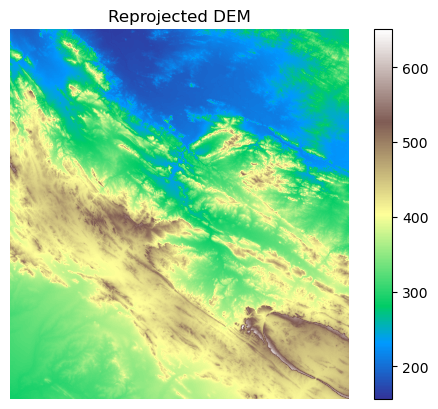

In [5]:
# plot the reprojected raster
with rio.open(dst_file) as src:
    dem_reprojected = src.read(1)
    plt.imshow(dem_reprojected,cmap='terrain')
    plt.colorbar()
    plt.title('Reprojected DEM')
    plt.axis('off')
    plt.show()